In [1]:

import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt,pi
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

from mpl_toolkits import mplot3d

In [3]:
device = torch.device("cpu")

batchsize = 128 
learning_rate = 1e-3

epochs = 100

n = 1000 
eps = 1

start = 0.
end = 1.

x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

xb1 = np.linspace(start,start, 100 )
yb1 = np.linspace(start,end, 100 ) 
xb1 = xb1.reshape(-1, 1)
yb1 = yb1.reshape(-1, 1)

xb2 = np.linspace(start,end, 100 )
yb2 = np.linspace(end,end, 100 ) 
xb2 = xb2.reshape(-1, 1)
yb2 = yb2.reshape(-1, 1)

xb3 = np.linspace(end,end, 100 )
yb3 = np.linspace(start,end, 100 ) 
xb3 = xb3.reshape(-1, 1)
yb3 = yb3.reshape(-1, 1)

xb4 = np.linspace(start,end, 100 )
yb4 = np.linspace(start,start, 100 ) 
xb4 = xb4.reshape(-1, 1)
yb4 = yb4.reshape(-1, 1)

xb = [xb1,xb2,xb3,xb4]
yb = [yb1,yb2,yb3,yb4]

cos2pix = np.array([[math.cos(2*math.pi*ind[0])] for ind in x])
cos2piy = np.array([[math.cos(2*math.pi*ind[0])] for ind in y])
sinpix = np.array([[math.sin(math.pi*ind[0])] for ind in x])
sinpiy = np.array([[math.sin(math.pi*ind[0])] for ind in y])

soln = ((sinpix)**2) * ((sinpiy)**2)

f = 8*(eps**2)*((math.pi)**4)*(cos2pix*cos2piy - cos2pix*sinpiy*sinpiy - cos2piy*sinpix*sinpix) - 2*((math.pi)**2)*(cos2pix*sinpiy*sinpiy + cos2piy*sinpix*sinpix)




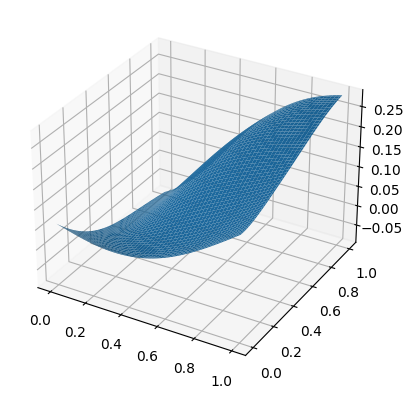

Train Epoch: 0 
Total Loss: 789965.5000000000 	Criterion Loss: 789965.3750000000 	 Loss BC 0.111267
Actual loss: 0.105247
elapse time in parallel =  24.780905723571777


In [19]:

def train(device,x,y,f,soln,xb,yb,eps,learning_rate,epochs):
	xnet = torch.Tensor(x).to(device)
	ynet = torch.Tensor(y).to(device) 
	f = torch.Tensor(f).to(device) 
	xb1,xb2,xb3,xb4 = xb
	yb1,yb2,yb3,yb4 = yb
	xb1 = torch.Tensor(xb1).to(device) 	
	yb1 = torch.Tensor(yb1).to(device) 
	xb2 = torch.Tensor(xb2).to(device) 	
	yb2 = torch.Tensor(yb2).to(device) 
	xb3 = torch.Tensor(xb3).to(device) 	
	yb3 = torch.Tensor(yb3).to(device) 
	xb4 = torch.Tensor(xb4).to(device) 	
	yb4 = torch.Tensor(yb4).to(device) 

	h_n = 128
	input_n = 2  
	class Swish(nn.Module):
		def __init__(self, inplace=True):
			super(Swish, self).__init__()
			self.inplace = inplace

		def forward(self, x):
			if self.inplace:
				x.mul_(torch.sigmoid(x))
				return x
			else:
				return x * torch.sigmoid(x)
	

	class Net(nn.Module):
		def __init__(self):
			super(Net, self).__init__()
			self.main = nn.Sequential(
				nn.Linear(input_n,h_n),
				nn.Tanh(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
				Swish(),
				nn.Linear(h_n,h_n),
        		Swish(),
				nn.Linear(h_n,1),
			)		
		def forward(self,x):		
			output = self.main(x)
			return  output

	
	net = Net().to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(x,y,f):
		x.requires_grad = True
		y.requires_grad = True
		points = torch.cat((x,y),1) 
		U = net(points)

		U = U.view(len(U),-1)
		U_x = torch.autograd.grad(U,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	def Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4):
		
		xb1.requires_grad = True
		yb1.requires_grad = True
		xb2.requires_grad = True
		yb2.requires_grad = True
		xb3.requires_grad = True
		yb3.requires_grad = True
		xb4.requires_grad = True
		yb4.requires_grad = True
	
		loss_f = nn.MSELoss()


		net1 = torch.cat((xb1, yb1), 1)
		out1 = net(net1)
		ub1 = out1.view(len(out1), -1)
		der_ub1 = torch.autograd.grad(ub1,xb1,grad_outputs=torch.ones_like(xb1),create_graph = True,only_inputs=True)[0]

		loss_dirichlet1 = loss_f(ub1,torch.zeros_like(ub1))
		loss_neumann1 = loss_f(der_ub1,torch.zeros_like(der_ub1))

		net2 = torch.cat((xb2, yb2), 1)
		out2 = net(net2)
		ub2 = out2.view(len(out2), -1)
		der_ub2 = torch.autograd.grad(ub2,yb2,grad_outputs=torch.ones_like(yb2),create_graph = True,only_inputs=True)[0]

		loss_dirichlet2 = loss_f(ub2,torch.zeros_like(ub2))
		loss_neumann2 = loss_f(der_ub2,torch.zeros_like(der_ub2))

		net3 = torch.cat((xb3, yb3), 1)
		out3 = net(net3)
		ub3 = out3.view(len(out3), -1)
		der_ub3 = torch.autograd.grad(ub3,xb3,grad_outputs=torch.ones_like(xb3),create_graph = True,only_inputs=True)[0]

		loss_dirichlet3 = loss_f(ub3,torch.zeros_like(ub3))
		loss_neumann3 = loss_f(der_ub3,torch.zeros_like(der_ub3))

		net4 = torch.cat((xb4, yb4), 1)
		out4 = net(net4)
		ub4 = out4.view(len(out4), -1)
		der_ub4 = torch.autograd.grad(ub4,yb4,grad_outputs=torch.ones_like(yb4),create_graph = True,only_inputs=True)[0]

		loss_dirichlet4 = loss_f(ub4,torch.zeros_like(ub4))
		loss_neumann4 = loss_f(der_ub4,torch.zeros_like(der_ub4))

		total_loss = loss_dirichlet1 + loss_neumann1 + loss_dirichlet2 + loss_neumann2 + loss_dirichlet3 + loss_neumann3 + loss_dirichlet4 + loss_neumann4 
		return total_loss

	losses = []
	tic = time.time()

	xx = np.linspace(0.,1.,100);yy = np.linspace(0.,1.,100)
	xx,yy = np.meshgrid(xx,yy)

	for epoch in range(epochs):
		if epoch == 50:
			learning_rate = 0.0001
			new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
			optimizer = new_optimizer

		net.zero_grad()
		loss_eqn = Loss_criterion(xnet,ynet,f)
		loss_bc = Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
		loss = loss_eqn + loss_bc
		loss.backward()
			
		optimizer.step() 
		points = torch.cat((xnet,ynet),1)
		U = net(points)
		z = U.detach().numpy()
		actual_loss = np.square(soln - z).mean()
		if epoch % 5 == 0:
			ax = plt.axes(projection='3d')
			ax.plot_surface(xx,yy,z.reshape(100,100))
			plt.show()
		print('Train Epoch: {} \nTotal Loss: {:.10f} \tCriterion Loss: {:.10f} \t Loss BC {:.6f}\tActual loss: {:.6f}'.format(
			epoch, loss.item(),loss_eqn.item(),loss_bc.item(),actual_loss))
		losses.append([loss.item(),loss_eqn.item(),loss_bc.item()])

	toc = time.time()
	elapseTime = toc - tic
	print ("elapse time in parallel = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output 

output = train(device,x,y,f,soln,xb,yb,eps,learning_rate,epochs)



In [9]:
z = output.detach().numpy()


In [15]:
np.square( soln - z).mean

0.1602087471130546